# Homework 2: ImageGPT

In [ ]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

In [2]:
from dgm_utils import plot_training_curves
from dgm_utils import show_samples, visualize_images

In [3]:
import numpy as np
from collections import defaultdict

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torch.utils.data as data
import torchvision.transforms as T
from torch.utils.data import random_split
from torch import optim

USE_CUDA = torch.cuda.is_available()

## Task: ImageGPT on MNIST

[ImageGPT](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) model uses Transformers on images.

Here you have to train this model on MNIST images. See paper for details.

Download the data from [here](https://drive.google.com/file/d/1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw/view?usp=sharing) (you could use the cell below).

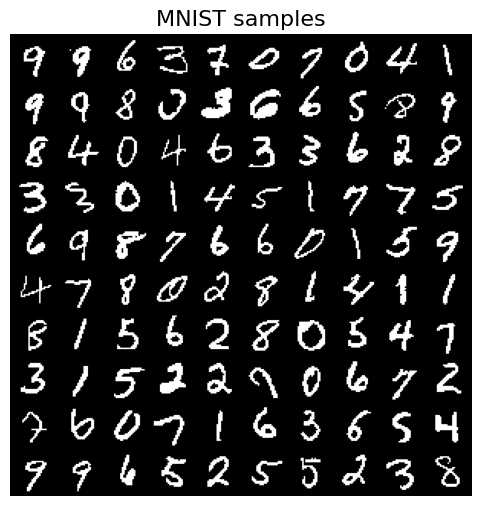

In [4]:
target_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.round(x).long())
])
dataset = datasets.MNIST(
        'MNIST', train=True, download=True, transform=target_transform
    )

train_size = int(0.9 * len(dataset))
train_data, test_data = random_split(
    dataset,
    [train_size, len(dataset) - train_size],
    generator=torch.Generator().manual_seed(0),
)
imgs = torch.cat([img*255 for img, _ in train_data])[:, None, :, :]
visualize_images(imgs, 'MNIST samples')

The transformer decoder takes an input sequence $x_1, \dots, x_n$
of discrete tokens and produces a d-dimensional embedding
for each position. The decoder is realized as a stack of
$L$ blocks, the $l$-th of which produces an intermediate embedding $h^l_1, \dots , h^l_n$
also of dimension $d$. Authors use GPT, so, let's build it. Transformers blocks are the basic building block of GPT2 model:<br>
$n^l= layer\_norm (h^l)$ <br> 
$a^l= h^l + multihead\_attention(n^l)$ <br> 
$h^{l+1}= a^l + mlp(layer\_norm (a^l))$ <br> 
To ensure proper conditioning when
training the Auto-regressive objective, we apply the standard upper
triangular mask to the $n×n$ matrix of attention logits.

In [5]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        # Masking attenton logits to ensure autoregressive property
        attn_mask = torch.triu(attn_mask, diagonal=1)

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x

Now we are ready to construct the main GPT2 model.

In [6]:
class GPT2(nn.Module):
    def __init__(
        self, embed_dim, num_heads, num_layers, num_positions, num_vocab, num_classes
    ):
        super(GPT2, self).__init__()

        self.embed_dim = embed_dim

        # start of sequence token
        self.sos = torch.nn.Parameter(torch.zeros(embed_dim))
        nn.init.normal_(self.sos)

        self.token_embeddings = nn.Embedding(num_vocab, embed_dim)
        self.position_embeddings = nn.Embedding(num_positions, embed_dim)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(Block(embed_dim, num_heads))

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_vocab, bias=False)
        self.clf_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, classify=False):
        """
        Expect input as shape [sequence len, batch]
        If classify, return classification logits
        """
        length, batch = x.shape
        h = self.token_embeddings(x.long())

        # prepend sos token
        sos = torch.ones(1, batch, self.embed_dim, device=x.device) * self.sos
        h = torch.cat([sos, h[:-1, :, :]], axis=0)

        # add positional embeddings
        positions = torch.arange(length, device=x.device).unsqueeze(-1)
        h = h + self.position_embeddings(positions).expand_as(h)

        # transformer
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)

        logits = self.head(h)

        if not classify:
            # return logits
            return logits

        h = torch.mean(h, dim=0)  # average pool over sequence
        # return classification logits and generative logits
        return self.clf_head(h), logits

Now let's use it to construct ImageGPT

In [7]:
def _to_sequence(x):
    """shape batch of images for input into GPT2 model"""
    x = x.view(x.shape[0], -1)  # flatten images into sequences
    x = x.transpose(0, 1).contiguous()  # to shape [seq len, batch]
    return x

In [15]:

class ImageGPT(nn.Module):
    def __init__(
        self,
        embed_dim=16,
        num_heads=2,
        num_layers=8,
        num_pixels=28,
        num_vocab=256,
        num_classes=10,
        **kwargs,
    ):
        super().__init__()
        self.gpt = GPT2(
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            num_positions=num_pixels * num_pixels,
            num_vocab=num_vocab,
            num_classes=num_classes,
        ).cuda()
        self.criterion = nn.CrossEntropyLoss()


    def forward(self, x):
        return self.gpt(x)

    def loss(self, batch, classify):
        x, y = batch
        x = _to_sequence(x).cuda()

        if classify:
            clf_logits, logits = self.gpt(x, classify=True)
            clf_loss = self.criterion(clf_logits, y)
            gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
            # joint loss for classification
            loss = clf_loss + gen_loss
        else:
            logits = self.gpt(x)
            loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))

        return {"total_loss": loss}

    def sample(model, context, length, num_samples=1):
        output = context.unsqueeze(-1).repeat_interleave(
            num_samples, dim=-1
        )  # add batch so shape [seq len, batch]

        pad = torch.zeros(1, num_samples, dtype=torch.long).cuda()  # to pad prev output
        with torch.no_grad():
            for _ in tqdm(range(length), leave=False):
                logits = model(torch.cat((output, pad), dim=0))
                logits = logits[-1, :, :]
                probs = F.softmax(logits, dim=-1)
                pred = torch.multinomial(probs, num_samples=1).transpose(1, 0)
                output = torch.cat((output, pred), dim=0)

        return output


In [16]:
def train_epoch(model, classify, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x, y in train_loader:
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        losses = model.loss((x, y), classify)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, classify, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x, y in data_loader:
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            losses = model.loss((x,y), classify)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    classify,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss',
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, classify, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, classify, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [48]:
# ====
EPOCHS = 40
BATCH_SIZE = 128
LR = 1e-3
N_LAYERS = 3
# ====

model = ImageGPT(num_layers=N_LAYERS)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader,
    classify=False,
    epochs=EPOCHS, 
    lr=LR, 
    use_cuda=True,
    use_tqdm=True
)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader,
    classify=True,
    epochs=EPOCHS, 
    lr=LR, 
    use_cuda=True,
    use_tqdm=True
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Even if the test loss is bigger than the value in assert, try to visualize train/test curves, it could find you to find the bug.

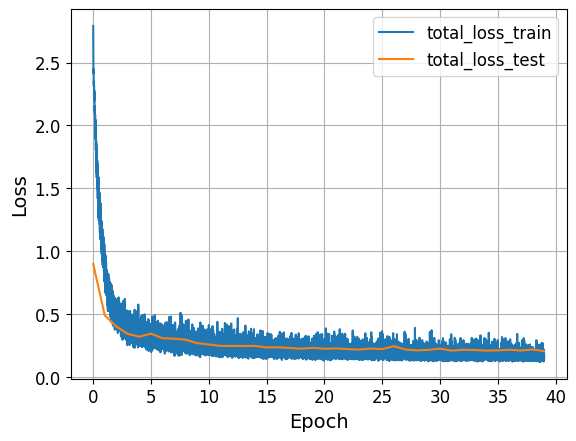

{'total_loss': [2.7909586429595947, 2.7080695629119873, 2.5909857749938965, 2.5693342685699463, 2.466256856918335, 2.539494276046753, 2.6369946002960205, 2.473270893096924, 2.4266257286071777, 2.4477789402008057, 2.415863513946533, 2.4272773265838623, 2.417027711868286, 2.426832437515259, 2.4255754947662354, 2.4322144985198975, 2.395456314086914, 2.40751051902771, 2.364558219909668, 2.3757874965667725, 2.3751754760742188, 2.3411741256713867, 2.3359484672546387, 2.345050811767578, 2.3345589637756348, 2.3366527557373047, 2.312418222427368, 2.3482706546783447, 2.3428752422332764, 2.3212573528289795, 2.307309865951538, 2.319571018218994, 2.30975604057312, 2.290152072906494, 2.3069305419921875, 2.267428159713745, 2.2710375785827637, 2.2820847034454346, 2.2608096599578857, 2.2623119354248047, 2.2779266834259033, 2.2405173778533936, 2.248459815979004, 2.1977479457855225, 2.214160203933716, 2.2036561965942383, 2.195838451385498, 2.256190538406372, 2.19991135597229, 2.1931464672088623, 2.189563

In [49]:
plot_training_curves(train_losses, test_losses)
print(train_losses)

Now we sample the new images from the model. You have to emphasize that the sampling from the autoregressive model is slow, because it is a sequential process.

  0%|          | 0/392 [00:00<?, ?it/s]

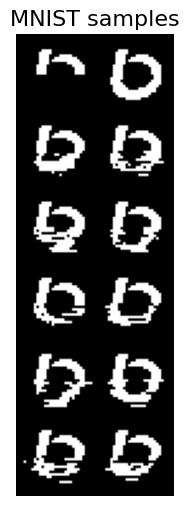

In [50]:
img, _ = test_data[0]
h, w = img.shape[-2:]
seq = img.reshape(-1) 

# first half of image is context
context = seq[: int(len(seq) / 2)]
context_img = np.pad(context, (0, int(len(seq) / 2))).reshape(h, w)
context = context.cuda()
# predict second half of image
preds = model.sample(context, int(len(seq) / 2), num_samples=10).cpu().numpy().transpose()
preds = preds.reshape(-1, h, w)

# combine context, preds, and truth for figure
samples = np.concatenate([context_img[None, ...], img, preds], axis=0)[:, None, :, :]
show_samples(samples, title='MNIST samples', nrow=2)